# Time Seires

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import math
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import Bounds

In [2]:
# задаем стандартную аналитическую экспоненциальную функцию описывающую приращение метрики АРПУ
# ниже будем подбирать к ней коэффициенты

def model_function(c, a, b, x):
    return c * np.exp(-a * (x + 1e-16)**b)

def model_exp_smooth(a, y, u):
    return a * y + (1 - a) * u

def model_function_poly_2(c, a, b, x):
    return a * x*x + b*x + c

In [3]:
# функция подбора коэффициентов
# тут что важно - R2 премирует за приближение больших значений, и это в целом нам подходит, 
# т.к. правильно оценить АРПУ в первые дни с одной стороны сложнее т.к. данных мало, 
# с другой стороны важнее, т.к. маркетинг получает результаты в течение пары дней а не ждет недели

def get_coefs(t):
    base_value = t[0]
    
    def ltv_error(x):
        error = 0.0
        for i in range(0, len(t)):
            error += (model_function(t[0], x[0], x[1], i) - t[i])**2
        return math.sqrt(error / len(t))
    

    x0 = np.array([0.5, 0.5])
    res = minimize(
            ltv_error,
            x0,
            method='nelder-mead',
            options={'xatol': 1e-8, 'disp': True}
    )
    return {'base_value' : base_value, 'a' : list(res.x)[0], 'b' : list(res.x)[1]}

def MSE(Y_true, Y_pred):
    return mean_squared_error(Y_true, Y_pred)


def get_coefs_sol_smooth(t):
    last_value = t[-1]
    base_value = t[0]
    
    Y_true = t.copy()
    def ltv_error(x):
        Y_pred = []
        Y_pred.append(base_value)
        for i in range(1, len(t)):
            Y_pred.append(model_exp_smooth(x[0], t[i-1], Y_pred[-1]))
        
        return MSE(Y_true, Y_pred)
    
    bounds = Bounds(0,1)
    x0 = np.array([0.5])
    res = minimize(
            ltv_error,
            x0,
            method='SLSQP',
            bounds= bounds,
    )
    return {'num_las': (len(t) - 1), 'a' : list(res.x)[0], 'last_value' : last_value}

def get_coefs_sol(t):
    base_value = t[0]
    Y_true = t.copy()
    def ltv_error(x):
        Y_pred = []
        for i in range(0, len(t)):
            Y_pred.append(model_function(t[0], x[0], x[1], i))
        return MSE(Y_true, Y_pred)

    x0 = np.array([0.5, 0.5])
    res = minimize(
            ltv_error,
            x0,
            method='nelder-mead',
            options={'xatol': 1e-8, 'disp': True}
    )
    return {'base_value' : base_value, 'a' : list(res.x)[0], 'b' : list(res.x)[1]}

def get_coefs_sol_poly(t):
    base_value = t[0]
    Y_true = t.copy()
    def ltv_error(x):
        Y_pred = []
        for i in range(0, len(t)):
            Y_pred.append(model_function_poly_2(t[0], x[0], x[1], i))
        return MSE(Y_true, Y_pred)

    x0 = np.array([0.5, 0.5])
    res = minimize(
            ltv_error,
            x0,
            method='nelder-mead',
            options={'xatol': 1e-8, 'disp': True}
    )
    return {'base_value' : base_value, 'a' : list(res.x)[0], 'b' : list(res.x)[1]}

In [4]:
# функция получения payment profile (т.е. по сути кривой накопления revenue)

def get_payment_profile(params, profile_range):
    [c, a, b] = params.values()
    
    if a == 0 and b == 0:
        return [1] * (profile_range)
    
    t = []
    for i in range(0, profile_range):
        t.append(model_function(c, a, b, i))
    
    return t


def get_payment_profile_poly(params, profile_range):
    [c, a, b] = params.values()
    
    if a == 0 and b == 0:
        return [1] * (profile_range)
    
    t = []
    for i in range(0, profile_range):
        t.append(model_function_poly_2(c, a, b, i))
    
    return t


def get_payment_profile_smooth(params, profile_range, seq):
    [c, a, b] = params.values()
    
    if a == 0 and b == 0:
        return [1] * (profile_range)
    
    t = []
    t.append(seq[0])
    for i in range(1, profile_range):
        if(i <= c):
            t.append(model_exp_smooth(a, seq[i-1], t[-1]))
        else:
            t.append(model_exp_smooth(a, t[-2], t[-1])) #После реальных данных работаем уже с аппроксимацией
  
    
    return t

In [5]:
# функция подсчета ошибки построения payment profile

def get_profile_error(real_data, approximation):
    profile_error = pd.DataFrame.from_dict({
            'lt' : range(len(real_data)), 
            'real_data' : real_data, 
            'approximation' : approximation
    })
    
    profile_error['real_data'] = profile_error['real_data'].cumsum()
    profile_error['real_data'] = profile_error['real_data'] / profile_error['real_data'].max()
    
    profile_error['approximation'] = profile_error['approximation'].cumsum()
    profile_error['approximation'] = profile_error['approximation'] / profile_error['approximation'].max()
    
    profile_error['error'] = profile_error['approximation'] / profile_error['real_data'] - 1
    profile_error['error'] = (profile_error['error'] * 100).apply(round).astype(int).astype(str) + '%'

    return profile_error


In [6]:
# Для примера на входном dataframe мы построили линейку в одном случае на 1-ом дне, в другом на недельных данных

input_dataframe = pd.read_csv('Quantum/input_dataframe.csv')

# to_approx = input_dataframe.loc[(input_dataframe.install_date == '2021-06-01') & (input_dataframe.platform == 'android')]['iap_revenue'].tolist()
to_approx = input_dataframe.loc[(input_dataframe.install_date >= '2021-06-01') & (input_dataframe.install_date <= '2021-06-07') & (input_dataframe.platform == 'android')].groupby('lt')['iap_revenue'].sum().tolist()

In [7]:
# ПРИМЕР 1. ВОТ В ЧЕМ ЗАДАЧА - пример апроксимации в лоб, т.е. по сути оверфитинга

# Функция построения payment profile 90 дней на самих 90 днях, 
# то ошибка выглядит "ок", от 0 до 7% в первые дни, при том что на старших днях в районе 0

coefs = get_coefs(to_approx[0:90])

p_profile = get_payment_profile(coefs, len(to_approx))

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    error_90 = get_profile_error(to_approx, p_profile)
    display(error_90)

Optimization terminated successfully.
         Current function value: 237.452906
         Iterations: 66
         Function evaluations: 127


,lt,real_data,approximation,error
0,0,0.077936,0.078182,0%
1,1,0.120348,0.118312,-2%
2,2,0.148299,0.152193,3%
3,3,0.178011,0.182293,2%
4,4,0.206022,0.209693,2%
5,5,0.244030,0.235007,-4%
6,6,0.278834,0.258630,-7%
7,7,0.300366,0.280839,-7%
8,8,0.318666,0.301836,-5%
9,9,0.338771,0.321779,-5%


In [8]:
# Когда мы применяем функцию построения payment profile 90 дней только на 30 днях, 
# т.к. по бизнеc необходимости мы не можем использовать только "старые" линейки прожившие 90 дней, 
# а зачастую хотим использовать последние 30 дней или иногда даже меньше, то мы строим функцию на первых n днях
# а применяем ко всей длине payment profile (на данном проекте это 90 дней, но может быть и больше и 365)

# и тут мы видим ошибку - payment profile построился на первых 30 днях и по факту стабильно начинает занижать 
# по сравнению с фактическими данными, Т.е. ошибка стабильно держится порядка 10% с первого до 30-ого дня, 
# что связано с тем что на фактических данных 90 дней после 30-ого дня было 1-59,2% = 40,8% 
# а в модельной апроксимации на 30-ти днях только  1-65,6% = 34,4%

coefs = get_coefs(to_approx[0:30])

p_profile = get_payment_profile(coefs, len(to_approx))

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    error_30 = get_profile_error(to_approx, p_profile)
    display(error_30)

Optimization terminated successfully.
         Current function value: 328.220804
         Iterations: 64
         Function evaluations: 126


,lt,real_data,approximation,error
0,0,0.077936,0.086090,10%
1,1,0.120348,0.132502,10%
2,2,0.148299,0.171315,16%
3,3,0.178011,0.205473,15%
4,4,0.206022,0.236293,15%
5,5,0.244030,0.264527,8%
6,6,0.278834,0.290667,4%
7,7,0.300366,0.315056,5%
8,8,0.318666,0.337949,6%
9,9,0.338771,0.359541,6%


In [9]:
# ПРИМЕР 2. 14 дней

coefs = get_coefs(to_approx[0:14])

p_profile = get_payment_profile(coefs, len(to_approx))

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    error_14 = get_profile_error(to_approx, p_profile)
    display(error_14)

Optimization terminated successfully.
         Current function value: 400.837326
         Iterations: 57
         Function evaluations: 110


,lt,real_data,approximation,error
0,0,0.077936,0.090113,16%
1,1,0.120348,0.139663,16%
2,2,0.148299,0.180931,22%
3,3,0.178011,0.217098,22%
4,4,0.206022,0.249598,21%
5,5,0.244030,0.279256,14%
6,6,0.278834,0.306613,10%
7,7,0.300366,0.332046,11%
8,8,0.318666,0.355838,12%
9,9,0.338771,0.378205,12%


In [13]:
df = pd.read_csv('Quantum/input_dataframe.csv', index_col = 0)
df = df.rename(columns = {'lt' : 'LT'})
df.head()

,install_date,platform,LT,installs,iap_revenue,ads_revenue
0,2021-05-01,android,0,22648,1191.316954,2311.294507
1,2021-05-01,ios,0,5666,547.490741,942.256531
2,2021-05-01,android,1,6737,443.113321,1234.498308
3,2021-05-01,ios,1,2170,262.806415,471.181635
4,2021-05-01,android,2,5132,412.194611,761.237707


In [14]:
to_approx = df.loc[(input_dataframe.install_date >= '2021-06-01')\
                                & (input_dataframe.install_date <= '2021-06-07')\
                                & (input_dataframe.platform == 'android')].groupby('LT')\
                                ['iap_revenue'].agg('sum').reset_index()

<AxesSubplot:xlabel='LT', ylabel='iap_revenue'>

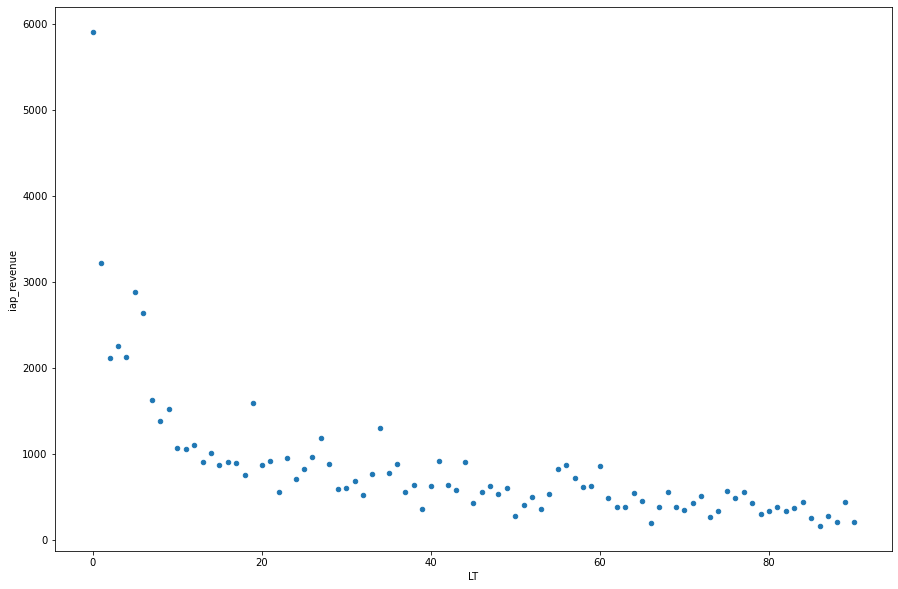

In [15]:
fig, ax = plt.subplots(figsize = (15, 10))
to_approx.plot.scatter(x = 'LT', y = 'iap_revenue', ax = ax)

<AxesSubplot:xlabel='LT', ylabel='iap_revenue'>

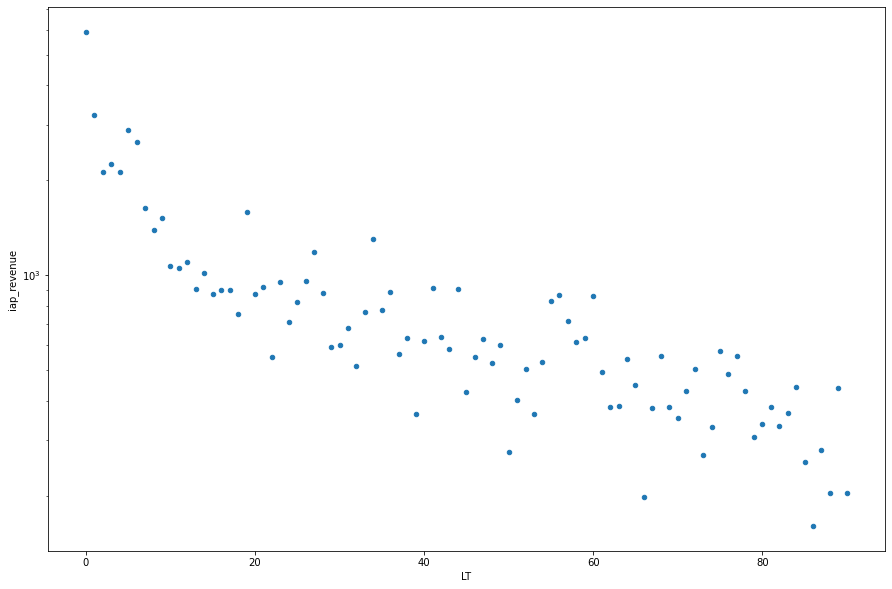

In [16]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.grid('both')
to_approx.plot.scatter(x = 'LT', y = 'iap_revenue', ax = ax, logy = True)

In [17]:
to_approx['log'] = np.log(to_approx['iap_revenue'] + 1)

In [18]:
to_approx

,LT,iap_revenue,log
0,0,5912.333409,8.684965
1,1,3217.434501,8.076650
2,2,2120.399597,7.659831
3,3,2253.958290,7.720887
4,4,2124.951655,7.661975
...,...,...,...
86,86,160.629840,5.085309
87,87,280.617864,5.640551
88,88,204.285824,5.324403
89,89,441.499435,6.092439


<AxesSubplot:xlabel='LT', ylabel='log'>

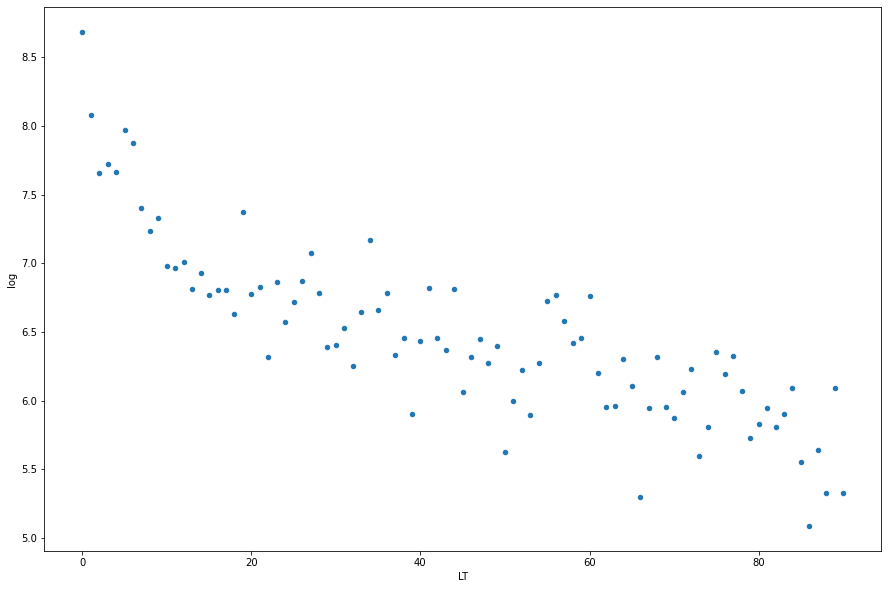

In [19]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.grid('both')
to_approx.plot.scatter(x = 'LT', y = 'log', ax = ax)

In [28]:
coefs = get_coefs_sol(to_approx.log[0:30].values)
#Обратный переход от логарифмического масштаба
p_profile = np.exp(get_payment_profile(coefs, len(to_approx.iap_revenue.values))) - 1
p_profile

Optimization terminated successfully.
         Current function value: 0.053075
         Iterations: 91
         Function evaluations: 171


array([5912.32974049, 3074.14801816, 2552.68814869, 2239.52249292,
       2017.90926138, 1848.14916083, 1711.75560252, 1598.58667787,
       1502.47383117, 1419.38680159, 1346.54955435, 1281.97052772,
       1224.17392689, 1172.03688689, 1124.68609385, 1081.42958834,
       1041.71030596, 1005.07354646,  971.1436502 ,  939.60692741,
        910.19893498,  882.69483959,  856.90201278,  832.65426695,
        809.80731587,  788.23516141,  767.82718956,  748.48581556,
        730.12455873,  712.66645671,  696.04275   ,  680.19178372,
        665.05808521,  650.59158476,  636.74695398,  623.48304115,
        610.76238712,  598.55080845,  586.81703693,  575.53240676,
        564.67058186,  554.20731762,  544.12025175,  534.38872033,
        524.99359541,  515.91714128,  507.14288687,  498.6555122 ,
        490.44074714,  482.48528079,  474.77668029,  467.30331794,
        460.05430553,  453.01943511,  446.18912553,  439.55437396,
        433.10671197,  426.83816558,  420.74121894,  414.80878

In [29]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    error_sol_30 = get_profile_error(to_approx.iap_revenue.values, p_profile)
    display(error_sol_30)

,lt,real_data,approximation,error
0,0,0.077936,0.084871,9%
1,1,0.120348,0.129001,7%
2,2,0.148299,0.165644,12%
3,3,0.178011,0.197793,11%
4,4,0.206022,0.226760,10%
5,5,0.244030,0.253290,4%
6,6,0.278834,0.277862,0%
7,7,0.300366,0.300810,0%
8,8,0.318666,0.322377,1%
9,9,0.338771,0.342753,1%


In [30]:
error_sol_30.error = error_sol_30.error.map(lambda x: float(x.replace('%', '')) / 100)
error_30.error = error_30.error.map(lambda x: float(x.replace('%', '')) / 100)
error_sol_30

AttributeError: 'float' object has no attribute 'replace'

Квадратичная ошибка аппроксимаци 30-ти дней по логарифмической шкале: 0.002003
Квадратичная ошибка аппроксимаци 30-ти дней базового решения 0.005986


Text(0.5, 1.0, 'Аппроксимация по 30-ти дням')

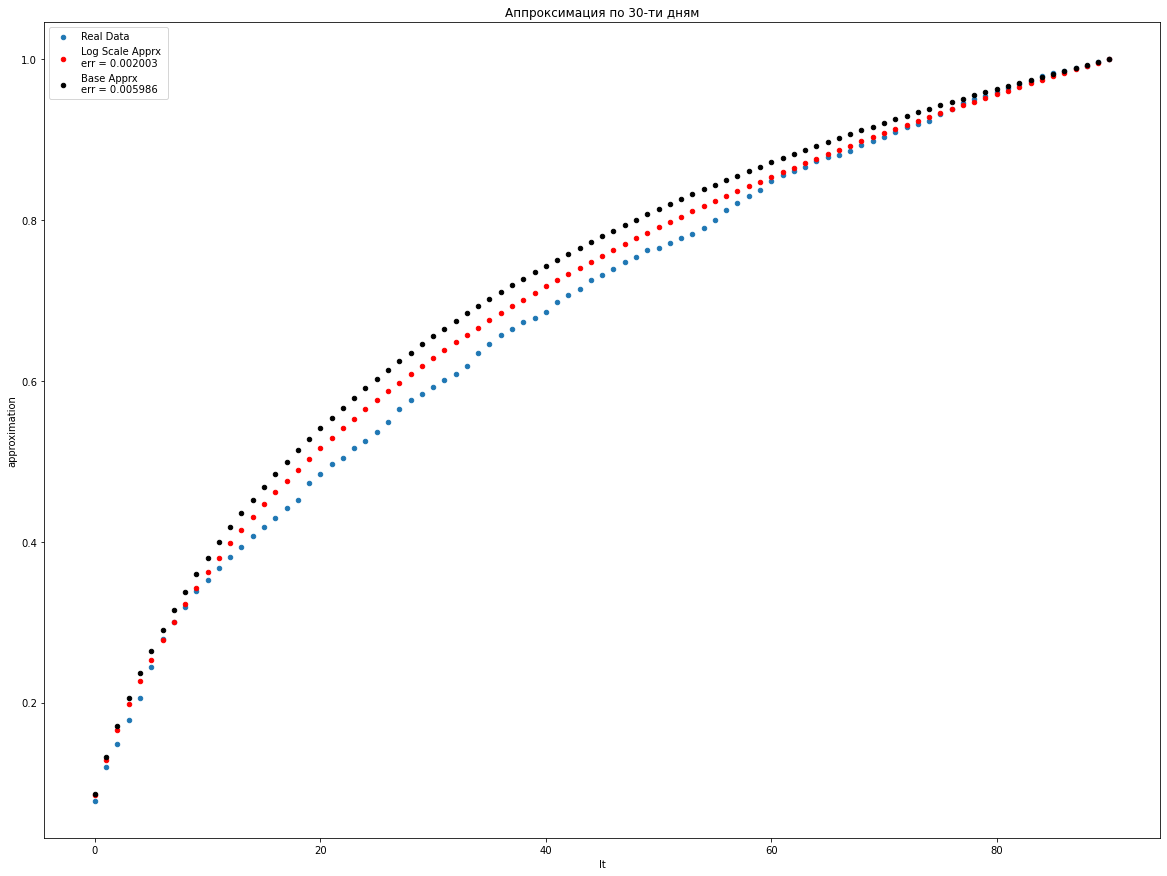

In [31]:
quad_err_sol_30 = sum(error_sol_30.error**2) / error_sol_30.error.shape[0]
print('Квадратичная ошибка аппроксимаци 30-ти дней по логарифмической шкале: {0:.6f}'.format(quad_err_sol_30))

quad_err_30 = sum(error_30.error**2) / error_30.error.shape[0]
print('Квадратичная ошибка аппроксимаци 30-ти дней базового решения {0:.6f}'.format(quad_err_30))

fig, ax = plt.subplots(figsize = (20, 15))
error_sol_30.plot.scatter(x = "lt", y = 'real_data', label = 'Real Data', ax = ax)
error_sol_30.plot.scatter(x = "lt", y = 'approximation',\
                          label  = 'Log Scale Apprx \nerr = {0:.6f}'.format(quad_err_sol_30), ax = ax, color = 'red')
error_30.plot.scatter(x = "lt", y = 'approximation',\
                      label = 'Base Apprx \nerr = {0:.6f}'.format(quad_err_30), ax = ax, color = 'black')
plt.title('Аппроксимация по 30-ти дням')